In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook_connected"

# Crypto Index Construction


## Background

Indices offer convenient benchmarks for investors to gauge the performance of a market or select verticals. For example, perhaps the most popular index, the S&P 500, tracks the top 500 public companies by market cap as a snapshot of the overall market. 

Crypto assets need their own index to track overall health of the crypto market especially as crypto expands and individual tracking becomes cumbersome. In this notebook, we examine several indexing methods for crypto assets. 


## S&P Methodology Overview

S&P offers 19 crypto indices with price data from Lukka. Aside from BTC and ETH indices (MegaCap is BTC+ETH), the rest are subsets of the Broad Digital Market (BDM) Index. All indices are relatively recent compared to S&P500 which started in 1957. The BDM which we will focus on launched only July 2021, with data starting Feb 2017.

|    | Index (Currency)                                    | Ticker  | Launch Date | First Value Date | Base Date  | Base Value |
|----|:----------------------------------------------------|:--------|:------------|:-----------------|:-----------|:-----------|
| 1  | S&P Bitcoin Index (USD)                             | SPBTC   | 05/03/2021  | 01/01/2014       | 01/01/2014 | 100        |
| 2  | S&P Bitcoin Index (CET Close) (USD)                 | SPBTCCC | 02/04/2022  | 01/03/2014       | 01/03/2014 | 100        |
| 3  | S&P Ethereum Index (USD)                            | SPETH   | 05/03/2021  | 04/04/2016       | 04/04/2016 | 100        |
| 4  | S&P Ethereum Index (CET Close) (USD)                | SPETHCC | 02/04/2022  | 04/04/2016       | 04/04/2016 | 100        |
| 5  | S&P Cryptocurrency MegaCap Index (USD)              | SPCMC   | 05/03/2021  | 02/28/2017       | 02/28/2017 | 100        |
| **6**  | **S&P Cryptocurrency Broad Digital Market Index (USD)** | SPCBDM  | 07/13/2021  | 02/28/2017       | 02/28/2017 | 100        |
| 7  | S&P Cryptocurrency LargeCap Index (USD)             | SPCBLC  | 07/13/2021  | 02/28/2017       | 02/28/2017 | 100        |
| 8  | S&P Cryptocurrency BDM Ex-MegaCap Index (USD)       | SPCBXM  | 07/13/2021  | 02/28/2017       | 02/28/2017 | 100        |
| 9  | S&P Cryptocurrency BDM Ex-LargeCap Index (USD)      | SPCBXL  | 07/13/2021  | 02/28/2017       | 02/28/2017 | 100        |
| 10 | S&P Cryptocurrency LargeCap Ex-MegaCap Index (USD)  | SPCLXM  | 07/13/2021  | 12/18/2017       | 12/18/2017 | 100        |
| 11 | S&P Cryptocurrency Top 5 Index (USD)                | SPCC5U  | 02/16/2023  | 03/16/2018       | 03/16/2018 | 1000       |
| 12 | S&P Cryptocurrency Top 10 Index (USD)               | SPCC10U | 02/16/2023  | 03/16/2018       | 03/16/2018 | 1000       |
| 13 | S&P Cryptocurrency Top 5 Equal Weight Index (USD)   | SPCC5   | 01/31/2022  | 03/16/2018       | 03/16/2018 | 1000       |
| 14 | S&P Cryptocurrency Top 10 Equal Weight Index (USD)  | SPCC10  | ]01/31/2022 | 03/16/2018       | 03/16/2018 | 1000       |
| 15 | S&P Cryptocurrency Top 10 Index (Singapore Close)   | SPCC10S | 09/20/2022  | 03/16/2018       | 03/16/2018 | 1000       |
| 16 | S&P Cryptocurrency Financials Index (USD)           | SPCFI   | 01/19/2023  | 12/15/2017       | 12/15/2017 | 100        |
| 17 | S&P Cryptocurrency DeFi Index (USD)                 | SPCDEFI | 01/19/2023  | 12/15/2017       | 12/15/2017 | 100        |
| 18 | S&P Cryptocurrency Financials Top 15 Index (USD)    | SPCFI15 | 01/19/2023  | 12/18/2020       | 12/18/2020 | 1000       |
| 19 | S&P Cryptocurrency DeFi Top 15 Index (USD)          | SPCDF15 | 01/19/2023  | 12/18/2020       | 12/18/2020 | 1000       |

S&P BDM Index is composed of market-cap weighted assets that meet the following criteria:

|           | Category    | Condition                                                                  |
|-----------|:------------|:---------------------------------------------------------------------------|
|         1 | Listing     | Listed on exchanges covered by Lukka Prime                                 |
|         2 | Volume     | Traded for at least 3 months on those exchanges                            |
|         3 | Volume     | Traded for at least 60 calendar days during those 3 months prior to reference rate rebalancing |
|         4 | Market Cap  | >= 10mn USD of "effective coin supply"                                     |
|         5 | Liquidity   | 3 months MDVT of 100k                                                      |
|         6 | White Paper | Verified published whitepaper                                              |
|         7 | Asset Type  | NOT a stablecoin or any pegged asset                                       |
|         8 | Rebalance   | last calendar days of February, May, August, and November                  | 


S&P BDM is calculated by inverse market cap, defined as effective circulating supply * price. The effective circulating supply is the circulating supply EOD on rebalancing date, which are the last calendar days of February, May, August, and November. Coin Supply is the total number of coins created since inception. Effective circulating supply is fixed between those dates.

S&P BDM is further segmented into large, mid, and small caps, with only large caps (#7, SPCBLC) currently implemented. S&P uses k-means clustering to segment.

We will replicate the market-cap weighted construction of the BDM, and k-means algorithm to create large, mid and small cap sub-indices and assess their usefulness. 

## Data Import
***
Coin Gecko is one of the few that offers free community tier price + volume. https://www.coingecko.com/en/api/documentation

In [2]:
import requests
import json

In [3]:
# https://api.coingecko.com/api/v3/coins/list?include_platform=false

coins_id_response = requests.get('https://api.coingecko.com/api/v3/coins/list?include_platform=false')
print(coins_id_response.status_code)
type(coins_id_response.json())

200


list

In [4]:
coins_id = pd.DataFrame.from_dict(coins_id_response.json())
display(coins_id)

,id,symbol,name
0,01coin,zoc,01coin
1,0chain,zcn,Zus
2,0vix-protocol,vix,0VIX Protocol
3,0x,zrx,0x
4,0x0-ai-ai-smart-contract,0x0,0x0.ai: AI Smart Contract
...,...,...,...
11285,zyberswap,zyb,Zyberswap
11286,zynecoin,zyn,Zynecoin
11287,zyro,zyro,Zyro
11288,zyrri,zyr,Zyrri


There are 11k+ coins offered on Coin Gecko, and vast majority of them are likely not listed on major centralized exchanges, which is a condition for index inclusion.

We don't have access to Lukka Prime which S&P uses, but we could refer to Coin Metrics, another leading data provider.

Coin Metrics provides a global median price which is the benchmark by which other markets are compared. According to their docs, it is calculated by taking median price of an asset from the following 8 exchanges:			
1. Coinbase
2. Poloniex
3. Bittrex
4. Gemini
5. Kraken
6. Binance
7. Bitstamp
8. itBit
										
Reference					
https://docs.coinmetrics.io/market-data/methodologies/market-selection-framework					
					
To simplify, we will include any token that is listed on Coinbase. We use Coin Metrics community API to isolate those tokens: https://docs.coinmetrics.io/api/v4/

In [5]:
cm_assets_response = requests.get('https://community-api.coinmetrics.io/v4/catalog/assets?pretty=true')
print(cm_assets_response.status_code)
type(cm_assets_response.json())


200


dict

In [6]:
cm_assets_response.json().keys()

dict_keys(['data'])

In [7]:
cm_assets = pd.DataFrame.from_dict(cm_assets_response.json()['data'])
display(cm_assets)

,asset,full_name,exchanges,markets,metrics,experimental,atlas
0,100x,100xCoin,[gate.io],[gate.io-100x-usdt-spot],NaN,NaN,NaN
1,10set,Tenset,"[gate.io, lbank]","[gate.io-10set-usdt-spot, lbank-10set-usdt-spot]",NaN,NaN,NaN
2,18c,Block 18,[huobi],"[huobi-18c-btc-spot, huobi-18c-eth-spot]",NaN,NaN,NaN
3,1art,ArtWallet,[gate.io],[gate.io-1art-usdt-spot],NaN,NaN,NaN
4,1box,1BOX,[zb.com],[zb.com-1box-usdt-spot],NaN,NaN,NaN
...,...,...,...,...,...,...,...
3067,zsc,Zeusshield,"[gate.io, hitbtc]","[gate.io-zsc-eth-spot, gate.io-zsc-usdt-spot, ...",NaN,NaN,NaN
3068,zusd,ZUSD,"[bittrex, liquid]","[bittrex-zusd-usdt-spot, liquid-btc-zusd-spot,...",NaN,NaN,NaN
3069,zwap,Zilswap,"[cex.io, liquid]","[cex.io-zwap-usd-spot, liquid-zwap-btc-spot, l...",NaN,NaN,NaN
3070,zyn,Zynecoin,"[bibox, hitbtc]","[bibox-zyn-usdt-spot, hitbtc-zyn-usdt-spot]",NaN,NaN,NaN


In [8]:
coinbase_tickers = cm_assets[cm_assets['exchanges'].isin([x for x in cm_assets['exchanges'].values if "coinbase" in str(x)])]
display(coinbase_tickers)

,asset,full_name,exchanges,markets,metrics,experimental,atlas
6,1inch,1inch,"[bibox, binance, binance.us, bitfinex, bitstam...","[bibox-1inch-usdt-spot, binance-1INCHUSDT-futu...","[{'metric': 'AdrActCnt', 'frequencies': [{'fre...",NaN,NaN
18,aave,Aave,"[bibox, binance, binance.us, bitfinex, bitmex,...","[bibox-aave-btc-spot, bibox-aave-eth-spot, bib...","[{'metric': 'AdrActCnt', 'frequencies': [{'fre...",NaN,NaN
25,abt,Arcblock,"[bibox, bithumb, bittrex, coinbase, gate.io, h...","[bibox-abt-btc-spot, bibox-abt-eth-spot, bithu...","[{'metric': 'ReferenceRate', 'frequencies': [{...",NaN,NaN
35,ach,Alchemy Pay,"[binance, binance.us, bittrex, bybit, coinbase...","[binance-ACHUSDT-future, binance-ach-btc-spot,...","[{'metric': 'CapMrktEstUSD', 'frequencies': [{...",NaN,NaN
39,acs,Access Protocol,"[bibox, bybit, coinbase, gate.io, kucoin, lban...","[bibox-acs-usdt-spot, bybit-acs-usdt-spot, coi...",NaN,NaN,NaN
...,...,...,...,...,...,...,...
3017,yfi,yearn.finance,"[bibox, binance, binance.us, bitfinex, bitmex,...","[bibox-yfi-usdt-spot, binance-YFIUSDT-future, ...","[{'metric': 'AdrActCnt', 'frequencies': [{'fre...",NaN,NaN
3019,yfii,DFI.Money,"[binance, cex.io, coinbase, ftx, gate.io, hitb...","[binance-YFIIUSDT-future, binance-yfii-bnb-spo...","[{'metric': 'CapMrktEstUSD', 'frequencies': [{...",NaN,NaN
3041,zec,Zcash,"[bibox, binance, binance.us, bitfinex, bithumb...","[bibox-zec-usdt-spot, binance-ZECUSDT-future, ...","[{'metric': 'AdrActCnt', 'frequencies': [{'fre...",NaN,True
3046,zen,Horizen,"[bibox, binance, binance.us, bittrex, bybit, c...","[bibox-zen-usdt-spot, binance-ZENUSDT-future, ...","[{'metric': 'CapMrktEstUSD', 'frequencies': [{...",NaN,NaN


In [10]:
#cross Coin Gecko and Coin Metrics
coins_sym = coins_id.loc[coins_id['symbol'].isin(coinbase_tickers.asset)]
display(coins_sym)

,id,symbol,name
3,0x,zrx,0x
25,1inch,1inch,1inch
77,aave,aave,Aave
112,aavegotchi,ghst,Aavegotchi
163,absolute-sync-token,ast,Absolute Sync
...,...,...,...
11052,xyo-network,xyo,XYO Network
11075,yearn-finance,yfi,yearn.finance
11092,yfii-finance,yfii,DFI.money
11170,zcash,zec,Zcash


There are 345 rows yet `coinbase_tickers` only return 256 rows, there are likely duplicates we should get rid of.

In [11]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(coins_sym[coins_sym['symbol'].duplicated()])

,id,symbol,name
185,acryptos,acs,ACryptoS
299,airswap,ast,AirSwap
526,apemove,ape,APEmove
553,aptos,apt,Aptos
598,arcblock,abt,Arcblock
709,assemble-protocol,asm,Assemble Protocol
715,ast-finance,ast,AST.finance
775,audius-wormhole,audio,Audius (Wormhole)
791,auroratoken,aurora,AuroraToken
814,avalanche-wormhole,avax,Avalanche (Wormhole)


In [12]:
coins_sym.loc[10106:10265]

,id,symbol,name
10152,uma,uma,UMA
10182,unicorn-token,uni,UNICORN
10193,unifi-protocol-dao,unfi,Unifi Protocol DAO
10209,unique-one,rare,Unique One
10213,uniswap,uni,Uniswap
10214,uniswap-wormhole,uni,Uniswap (Wormhole)


Duplicates will be a huge pain e.g uni stands for unicorn-token, uniswap, uniswap-wormhole. We try to match full name instead.

In [13]:
coins_id.loc[coins_id['name'].isin(coinbase_tickers.full_name)]

,id,symbol,name
3,0x,zrx,0x
25,1inch,1inch,1inch
77,aave,aave,Aave
112,aavegotchi,ghst,Aavegotchi
169,access-protocol,acs,Access Protocol
...,...,...,...
10811,wrapped-bitcoin,wbtc,Wrapped Bitcoin
10820,wrapped-centrifuge,wcfg,Wrapped Centrifuge
11075,yearn-finance,yfi,yearn.finance
11170,zcash,zec,Zcash


Much better results, though at the cost of 53 tokens, which we will take.

In [14]:
#cross Coin Gecko and Coin Metrics on name
coins_name = coins_id.loc[coins_id['name'].isin(coinbase_tickers.full_name)]
coins_name = coins_name.reset_index(drop=True)
display(coins_name['id'].values)

array(['0x', '1inch', 'aave', 'aavegotchi', 'access-protocol',
       'adventure-gold', 'aergo', 'aioz-network', 'airswap', 'alchemix',
       'alchemy-pay', 'aleph', 'algorand', 'amp-token', 'apecoin', 'api3',
       'aptos', 'aragon', 'arcblock', 'arpa', 'assemble-protocol',
       'audius', 'augur', 'aurora-dao', 'aurora-near', 'avalanche-2',
       'aventus', 'axelar', 'axie-infinity', 'badger-dao', 'balancer',
       'band-protocol', 'barnbridge', 'benqi', 'biconomy', 'binance-usd',
       'bitcoin', 'bitcoin-cash', 'bitdao', 'blockstack', 'blur',
       'bluzelle', 'boba-network', 'bonfida', 'braintrust', 'cardano',
       'cartesi', 'celer-network', 'celo', 'chain-2', 'chainlink',
       'chiliz', 'circuits-of-value', 'civic', 'coin98',
       'coinbase-wrapped-staked-eth', 'compound-governance-token',
       'convex-finance', 'coti', 'crypterium', 'cryptex-finance',
       'crypto-com-chain', 'dai', 'dash', 'decentraland',
       'defi-yield-protocol', 'derivadao', 'deso', 'dia

Next we want to grab their price and volume data from CoinGecko API. Note that Coin Gecko has a 10-30 rate limited API for free tier, so we use `ratelimit` library to call accordingly.

In [19]:
# 
# from ratelimit import limits, sleep_and_retry

# @sleep_and_retry
# @limits(calls=10, period=60) #follow 10-30 calls per min 
# def access_rate_limited_api(coin):
#     response = requests.get(f'https://api.coingecko.com/api/v3/coins/{coin}/market_chart?vs_currency=usd&days=365&interval=daily').json()
#     return response  

# coins_dict3 = dict()
# for coin in coins_name['id']:
#     coins_dict3[coin] = access_rate_limited_api(coin)


In [20]:
# # removed due to rate limit, next attempt
# len([k for k,v in coins_dict3.items() if  'status' in v])

In [21]:
# json_file = json.dumps(coins_dict3)
# with open('coins_dict3','w') as f:
#     f.write(json_file)

In [24]:
# don't want to go through that again...
# with open('data/coins_dict3') as f:
#     coins_dict3 = json.load(f)

In [29]:
print(f'''
{coins_dict3.keys()}
count: {len(coins_dict3.keys())}
''')


dict_keys(['0x', '1inch', 'aave', 'aavegotchi', 'access-protocol', 'adventure-gold', 'aergo', 'aioz-network', 'airswap', 'alchemix', 'alchemy-pay', 'aleph', 'algorand', 'amp-token', 'apecoin', 'api3', 'aptos', 'aragon', 'arcblock', 'arpa', 'assemble-protocol', 'audius', 'augur', 'aurora-dao', 'aurora-near', 'avalanche-2', 'aventus', 'axelar', 'axie-infinity', 'badger-dao', 'balancer', 'band-protocol', 'barnbridge', 'benqi', 'biconomy', 'binance-usd', 'bitcoin', 'bitcoin-cash', 'bitdao', 'blockstack', 'blur', 'bluzelle', 'boba-network', 'bonfida', 'braintrust', 'cardano', 'cartesi', 'celer-network', 'celo', 'chain-2', 'chainlink', 'chiliz', 'circuits-of-value', 'civic', 'coin98', 'coinbase-wrapped-staked-eth', 'compound-governance-token', 'convex-finance', 'coti', 'crypterium', 'cryptex-finance', 'crypto-com-chain', 'dai', 'dash', 'decentraland', 'defi-yield-protocol', 'derivadao', 'deso', 'dia-data', 'district0x', 'dogecoin', 'elastos', 'elrond-erd-2', 'enjincoin', 'eos', 'ethereum', 

In [30]:
coins_dict3['uniswap'].keys()

dict_keys(['prices', 'market_caps', 'total_volumes'])

In [31]:
def constructDF(coin, metric):
    df = pd.DataFrame(coins_dict3[coin][metric], columns = ['date', coin])
    df['date'] = pd.to_datetime(df['date'],unit='ms').dt.floor('d').astype(str)
    df = df.set_index('date')
    df = df[:-1]
    return df

In [32]:
price_df = constructDF('bitcoin', 'prices')
mcap_df = constructDF('bitcoin', 'market_caps')
volume_df = constructDF('bitcoin', 'total_volumes')

for coin in [x for x in list(coins_dict3.keys()) if x!= 'bitcoin']:
# for coin in list(coins_dict3.keys())[1:]:
    try:
        price_df = pd.concat([price_df, constructDF(coin, 'prices')], join='outer', axis=1)
        mcap_df = pd.concat([mcap_df, constructDF(coin, 'market_caps')], join='outer', axis=1)
        volume_df = pd.concat([volume_df, constructDF(coin, 'total_volumes')], join='outer', axis=1)
    except:
        pass

In [33]:
print(f'''
len price {len(price_df.columns.values)}
len mcap {len(mcap_df.columns.values)}
len volume {len(volume_df.columns.values)}

''')


len price 202
len mcap 202
len volume 202




In [35]:
# save for later
# price_df.to_csv('export/price-2023-03-19.csv')
# mcap_df.to_csv('export/mcap-2023-03-19.csv')
# volume_df.to_csv('export/volume-2023-03-19.csv')

In [36]:
volume_df.iloc[-1].sort_values(ascending=False).head(10)

litecoin       7.101451e+08
optimism       5.045233e+08
blockstack     4.939571e+08
shiba-inu      4.190547e+08
stepn          4.173396e+08
cardano        4.051813e+08
aptos          4.048192e+08
the-sandbox    3.524952e+08
the-graph      2.294721e+08
eos            1.894010e+08
Name: 2023-03-19, dtype: float64

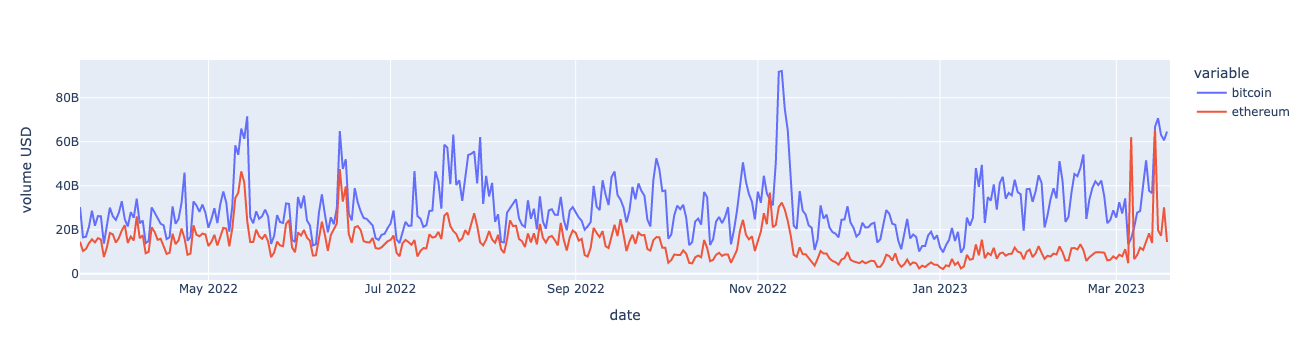

In [37]:
fig = px.line(volume_df, x=volume_df.index, y=['bitcoin','ethereum'], labels={'value':'volume USD'})
fig.show()

### Brief Excursion into Stablecoins

We want to get rid of stablecoins given they will not be part of the index. 

To get rid of stablecoins, we will look at coins with ~1 USD price peg and with minimum variance.

To do so, we use a non-sophiscated method by averaging price of 90 randomly sampled dates 10 times and pick the coins with highest occurances average price that falls between 1.05 and 0.95.

In [40]:
import random

stablecoin_candidates = []
i = 0
while i < 10:
    stablecoin_candidates = stablecoin_candidates + [k for k in price_df.columns if price_df[price_df.index.isin(random.sample(list(price_df.index),90))].mean()[k] < 1.05 and price_df[price_df.index.isin(random.sample(list(price_df.index),90))].mean()[k] >0.95]
    i += 1

In [41]:
from collections import Counter
Counter(stablecoin_candidates).most_common()

[('binance-usd', 10),
 ('dai', 10),
 ('euro-coin', 10),
 ('gemini-dollar', 10),
 ('musd', 10),
 ('tether', 10),
 ('usd-coin', 10),
 ('matic-network', 6),
 ('immutable-x', 5),
 ('decentraland', 3),
 ('blur', 2),
 ('goldfinch', 2),
 ('stepn', 2),
 ('liquity', 2),
 ('orca', 2),
 ('perpetual-protocol', 2),
 ('celo', 1),
 ('derivadao', 1)]

In [42]:
stablecoins = list(list(zip(*Counter(stablecoin_candidates).most_common()[:7]))[0])
print(stablecoins)

['binance-usd', 'dai', 'euro-coin', 'gemini-dollar', 'musd', 'tether', 'usd-coin']


In [43]:
stable_price_df = price_df[stablecoins][:-1].copy()
stable_mcap_df = mcap_df[stablecoins][:-1].copy()
stable_volume_df = volume_df[stablecoins][:-1].copy()

Before dropping stablecoins from index construction, let's see how they compare in terms of volume, market cap.

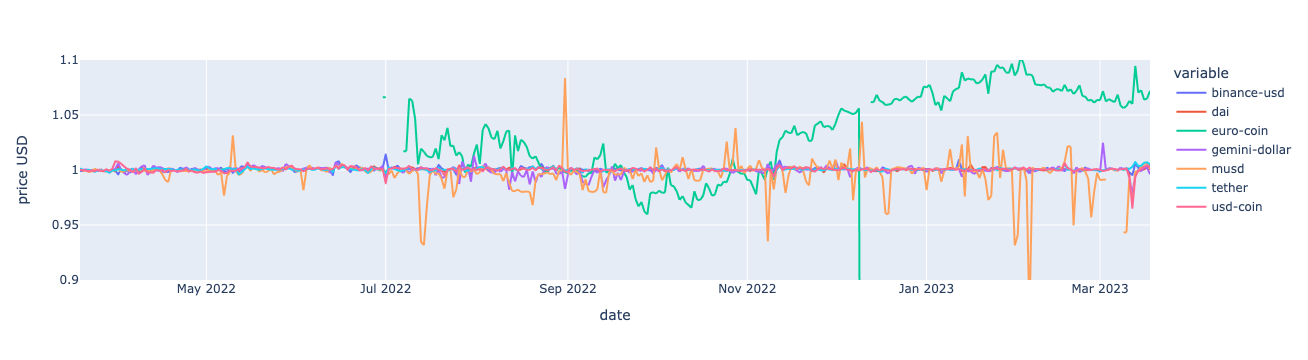

In [45]:
fig = px.line(stable_price_df, x=stable_price_df.index, y=stablecoins, labels={'value':'price USD'})
fig.update_yaxes(range=[0.9, 1.1])
# fig.update_traces(
#     visible='legendonly',
#     selector=lambda t: not t.name not in ['euro-coin','musd'],
# )
fig.show()

note: click euro-coin and musd in legends to show/disable on graph

We see large depegging in the [euro-coin](https://www.circle.com/en/euro-coin). Euro-coin is offered by Circle as a euro-denominated stablecoin much like their USDC. Given all price data is denominated in USD, we should expect "depegging" given FX. Also given other exchange aggregators like CMC do not exhibit such behavior, it is likely an outlier from Coin Gecko.

The other coin with depegging is [musd](https://www.circle.com/en/euro-coin). mUSD is backed by mStable and is backed by a basket of other stablecoins, an index of sorts:
- On Ethereum: USDC, USDT, DAI, sUSD
- On Polygon POS-Chain: USDC, USDT, DAI

In [48]:
stable_mcap_df['total'] = stable_mcap_df.sum(axis=1)
for coin in stable_mcap_df.columns[:-1]:
    stable_mcap_df[f'{coin}-pct'] = stable_mcap_df[coin]/stable_mcap_df['total']

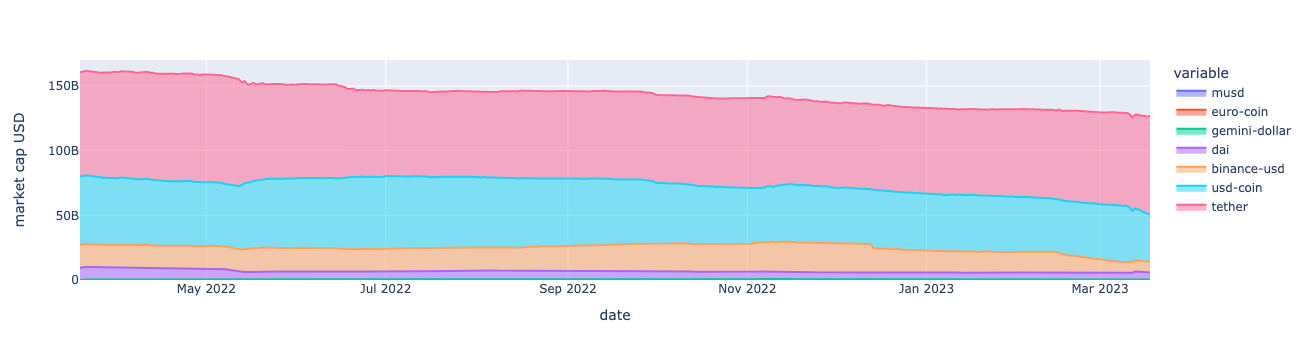

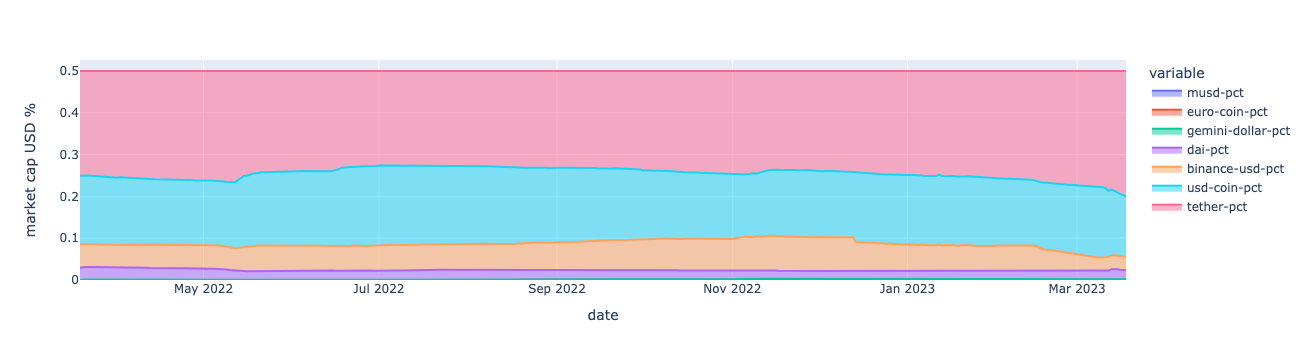

In [49]:
fig = px.area(stable_mcap_df, x=stable_mcap_df.index, y=list(stable_mcap_df.iloc[:,:7].iloc[-1].sort_values(ascending=True).index), labels={'value':'market cap USD'})
fig.show()

fig = px.area(stable_mcap_df, x=stable_mcap_df.index, y=list(stable_mcap_df.iloc[:,8:].iloc[-1].sort_values(ascending=True).index), labels={'value':'market cap USD %'})
fig.show()

In [50]:
stable_volume_df['total'] = stable_volume_df.sum(axis=1)
for coin in stable_volume_df.columns[:-1]:
    stable_volume_df[f'{coin}-pct'] = stable_volume_df[coin]/stable_volume_df['total']

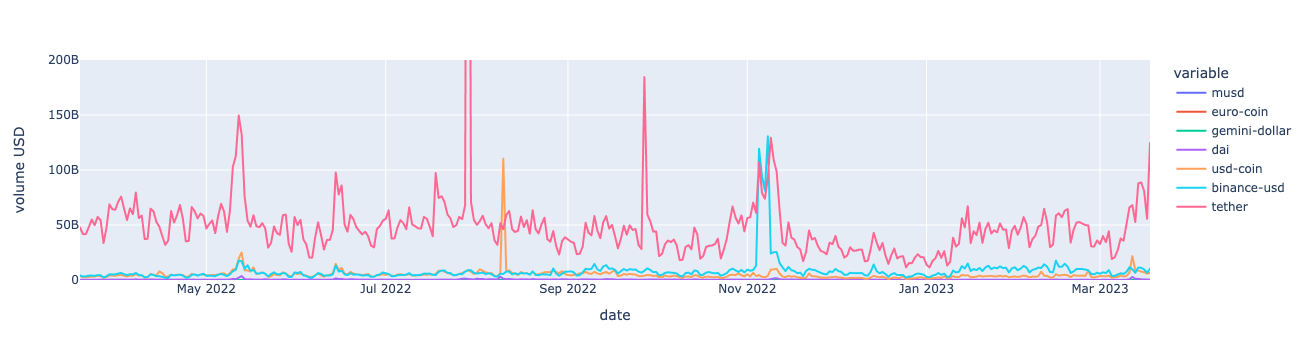

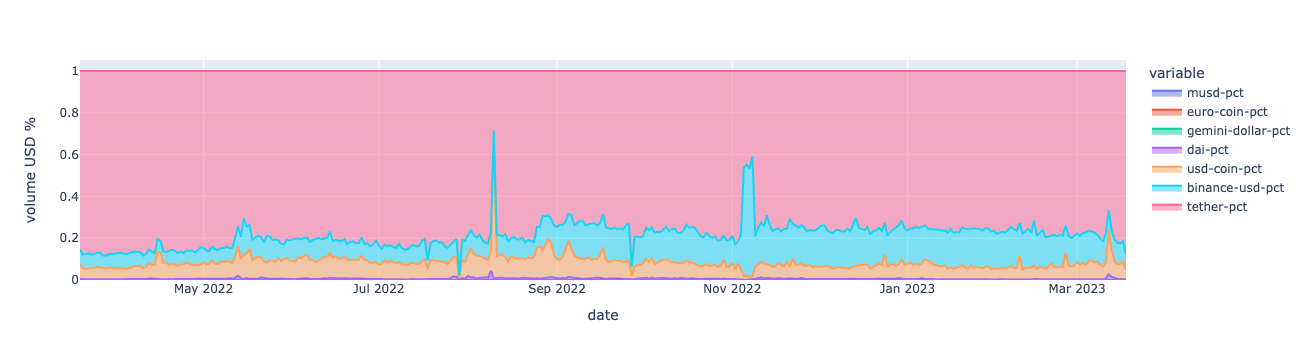

In [51]:
fig = px.line(stable_volume_df, x=stable_volume_df.index, y=list(stable_volume_df.iloc[:,:7].iloc[-1].sort_values(ascending=True).index), labels={'value':'volume USD'})
fig.update_yaxes(range=[0, 2e11])
fig.show()

fig = px.area(stable_volume_df, x=stable_volume_df.index, y=list(stable_volume_df.iloc[:,8:].iloc[-1].sort_values(ascending=True).index), labels={'value':'volume USD %'})
fig.show()

We see that stablecoin market is dominated by tether (USDT) and usd-coin (USDC).

USDT has gained its dominance in market cap and trading volume over USDC since early March 2023 due to 
- Circle's admission of deposits in failed SVB and Silvergate
- Tether's claim and having no exposure to either



### Even Briefer Excursion into Wrapped Assets

Wrapped assets are also considered pegged assets, and therefore we remove them the pool.

In [52]:
wrapped_assets = [x for x in price_df.columns.values if 'wrapped' in str(x)]
print(wrapped_assets)

['coinbase-wrapped-staked-eth', 'wrapped-bitcoin', 'wrapped-centrifuge']


In [53]:
coin_price_df = price_df[:-1].drop(columns=stablecoins+wrapped_assets).copy()
coin_mcap_df = mcap_df[:-1].drop(columns=stablecoins+wrapped_assets).copy()
coin_volume_df = volume_df[:-1].drop(columns=stablecoins+wrapped_assets).copy()

## BDM-Coinbase Index Criteria
***

We now create an index of coins listed on Coinbase by inverse-market cap. Here are our adjusted parameters from the S&P:

|           | Category    | Condition                                                                  | Revised|
|-----------|:------------|:---------------------------------------------------------------------------|-|
|         1 | Listing     | Listed on exchanges covered by Lukka Prime                                 | Listed on Coinbase|
|         2 | Volume      | Traded for at least 3 months on those exchanges                            | Traded for at least 90 days on Coinbase|
|         3 | Volume      | Traded for at least 2/3 months prior to reference rate rebalancing | At least 60 days|
|         4 | Market Cap  | >= 10mn USD of "effective coin supply"                                     | >=10mn USD of Coin Gecko market cap|
|         5 | Liquidity   | 3 months MDVT of 100k                                                      | >100k USD of 90d Coin Gecko daily volume |
|         6 | White Paper | Verified published whitepaper                                              | N/A |
|         7 | Asset Type  | NOT a stablecoin or any pegged asset                                       | Same |
|         8 | Rebalance   | last calendar days of February, May, August, and November                  | Same |




#### Condition 1: Listed on Coinbase

Since our universe of coins is from coinbase, this condition is fulfilled.

#### Condition 2: Traded for at least 90d on Coinbase

In [54]:
coin_volume_df.isna().sum().sort_values(ascending=False).head(10)

access-protocol    333
blur               332
hashflow           233
aptos              214
axelar             192
forta               88
optimism            73
project-galaxy      47
math                 1
media-network        1
dtype: int64

In [55]:
# exclude coins that had non trading days greater than 90
cond2 = [x for x in coin_volume_df.columns if coin_volume_df[x].isna().sum() > (90)]
print(cond2)

['access-protocol', 'aptos', 'axelar', 'blur', 'hashflow']


#### Condition 3: Traded for at least 60d in 90d prior to reference rate rebalancing 

In [56]:
coin_volume_df.iloc[-91:,:].isna().sum().sort_values(ascending=False)

access-protocol    59
blur               58
bitcoin             0
numeraire           0
mirror-protocol     0
                   ..
dogecoin            0
elastos             0
elrond-erd-2        0
enjincoin           0
zencash             0
Length: 192, dtype: int64

In [57]:
# exclude coins that had non trading days within the past 90 days greater than 30
cond3 = [x for x in coin_volume_df.columns if coin_volume_df.iloc[-91:,:][x].isna().sum() > 30]
print(cond3)

['access-protocol', 'blur']


#### Condition 4: >= 10mn USD market cap

In [58]:
coin_mcap_df.iloc[-1].sort_values()

mines-of-dalarnia     0.000000e+00
moss-carbon-credit    0.000000e+00
highstreet            0.000000e+00
monacoin              0.000000e+00
assemble-protocol     0.000000e+00
                          ...     
matic-network         1.110430e+10
cardano               1.225984e+10
ripple                1.939523e+10
ethereum              2.156606e+11
bitcoin               5.300382e+11
Name: 2023-03-18, Length: 192, dtype: float64

In [59]:
# exclude coins that have mcap below 10mn
cond4 = [x for x in coin_mcap_df.columns if coin_mcap_df.iloc[-1][x] < 10e6]
print(cond4)

['assemble-protocol', 'braintrust', 'crypterium', 'cryptex-finance', 'defi-yield-protocol', 'highstreet', 'jupiter', 'media-network', 'mines-of-dalarnia', 'monacoin', 'monavale', 'moss-carbon-credit', 'pangolin', 'pawtocol', 'rai', 'suku', 'sylo', 'te-food']


#### Condition 5: >= 90d 100k median daily traded volume

In [60]:
coin_volume_df.rolling(90).median().iloc[-1].sort_values()

tbtc                  8.527545e+02
pawtocol              4.733062e+04
moss-carbon-credit    5.240692e+04
aventus               5.685774e+04
derivadao             9.208194e+04
                          ...     
ripple                1.083678e+09
ethereum              8.459146e+09
bitcoin               3.298124e+10
access-protocol                NaN
blur                           NaN
Name: 2023-03-18, Length: 192, dtype: float64

In [61]:
cond5 = [x for x in coin_volume_df.columns if coin_volume_df[x].rolling(90).median().iloc[-1] < 100000]
print(cond5)

['aventus', 'derivadao', 'monacoin', 'moss-carbon-credit', 'pawtocol', 'tbtc']


#### Condition 6: Published Whitepaper

Assuming they all have it (next step: find api that provides this classification)

#### Condition 7: Not a stablecoin or pegged asset

Already excluded

In [62]:
cond_exclude = set(cond2 + cond3 + cond4 + cond5)
bdm_price_df = coin_price_df.drop(columns=cond_exclude).copy()
bdm_mcap_df = coin_mcap_df.drop(columns=cond_exclude).copy()
bdm_volume_df = coin_volume_df.drop(columns=cond_exclude).copy()

## BDM-Coinbase Index Construction

We construct the cap-weighted index following S&P's rebalance dates.


In [63]:
rebal_dates = [
    bdm_price_df.index[0],
    '2022-05-31',
    '2022-08-31',
    '2022-11-30',
    '2023-02-28',
    bdm_price_df.index[-1],
]

In [64]:
rebal_dates[1:][:-1]

['2022-05-31', '2022-08-31', '2022-11-30', '2023-02-28']

In [65]:
rebal_weights = dict()
for date in rebal_dates[1:][:-1]:
    rebal_weights[date] = bdm_mcap_df.loc[date] / bdm_mcap_df.loc[date].sum()

In [66]:
rebal_weights[rebal_dates[5]] = rebal_weights[rebal_dates[4]]
rebal_weights[rebal_dates[0]] = rebal_weights[rebal_dates[1]]

In [67]:
rebal_weights['2022-05-31']

bitcoin          0.587998
0x               0.000353
1inch            0.000405
aave             0.001576
aavegotchi       0.000077
                   ...   
uniswap          0.002505
voxies           0.000023
yearn-finance    0.000258
zcash            0.001204
zencash          0.000276
Name: 2022-05-31, Length: 166, dtype: float64

We will matrix multiply coins price with weights.

In [71]:
print(f'''
shape coin price matrix {bdm_price_df.loc[rebal_dates[0]:rebal_dates[1]].shape}
shape coin weight matrix {rebal_weights['2022-05-31'].shape}
''')


shape coin price matrix (74, 166)
shape coin weight matrix (166,)



In [72]:
# dot product won't work if there's NaN value
import math
[x for x in rebal_weights['2022-05-31'].index if math.isnan(rebal_weights['2022-05-31'][x])==True]

['forta']

In [73]:
rebal_df = pd.DataFrame(bdm_price_df.loc[rebal_dates[0]:rebal_dates[1]].fillna(0).dot(rebal_weights[rebal_dates[1]].fillna(0)), columns=['BDM'])

for i in range(1,5):
    rebal_df2 = pd.DataFrame(bdm_price_df.loc[rebal_dates[i]:rebal_dates[i+1]].fillna(0).dot(rebal_weights[rebal_dates[i+1]].fillna(0)), columns=['BDM'])
    rebal_df = pd.concat([rebal_df, rebal_df2], axis=0)

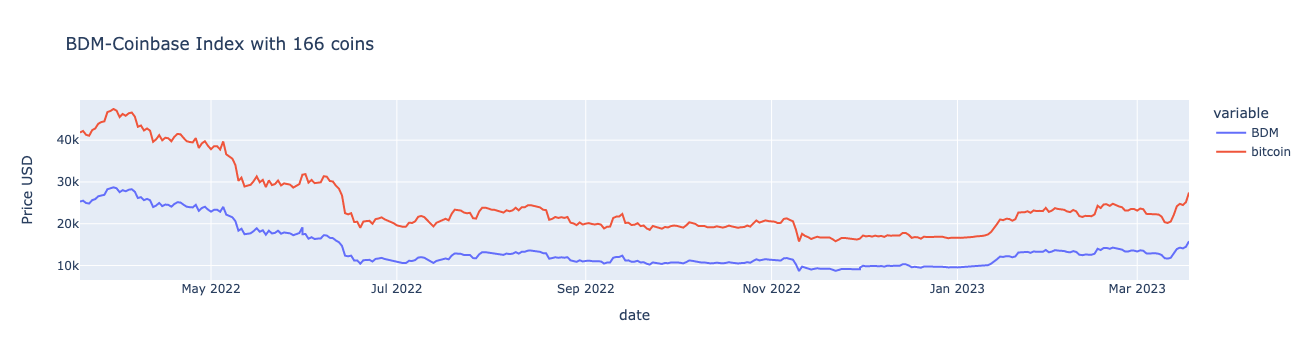

In [74]:
fig = px.line(
    rebal_df, 
    x=rebal_df.index, 
    y=['BDM'], 
    labels={'value':'Price USD'}, 
    title=f"BDM-Coinbase Index with {len(bdm_price_df.columns)} coins"
)
fig.add_scatter(
    x=bdm_price_df.index, 
    y=bdm_price_df['bitcoin'], mode='lines', name='bitcoin')
fig.show()

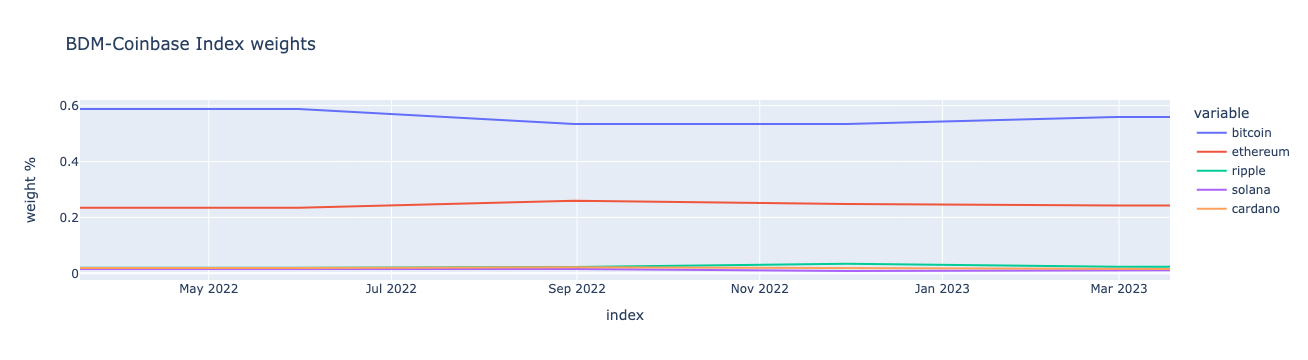

In [76]:
bdm_weights_df = pd.DataFrame.from_dict(rebal_weights).T.sort_index(axis=0)
fig = px.line(
    bdm_weights_df, 
    x=bdm_weights_df.index, 
    y=['bitcoin','ethereum','ripple','solana','cardano'], 
    labels={'value':'weight %'}, 
    title=f"BDM-Coinbase Index weights"
)
fig.show()

In [77]:
def performanceSummary(series):
    # annualized daily sharpe
    absolute_ret = series[-1] / series[0] - 1
    dret = [i / j - 1 for i, j in zip(series[1:], series[:-1])]
    mean_dret = np.mean(dret)
    vol_dret = np.std(dret)
    dsharpe = mean_dret / vol_dret
    annualized_dsharpe = dsharpe * (365**0.5)
    # annualized log daily sharpe
    ln_dret = [np.log(i / j) for i, j in zip(series[1:], series[:-1])]
    mean_ln_dret = np.mean(ln_dret)
    vol_ln_dret = np.std(dret)
    lnsharpe = mean_ln_dret / vol_ln_dret
    annualized_lnsharpe = lnsharpe * (365**0.5)
    
    print(f'''
    {series.name}
    {series.index[0]} to {series.index[-1]}
    {len(series.index)} days
    LOG RETURNS:
        annualized sharpe: {annualized_lnsharpe}
        average daily log ret: {mean_dret}
        vol daily log ret: {vol_dret}
    SIMPLE RETURNS:
        annualized sharpe: {annualized_dsharpe}
        average daily ret: {mean_ln_dret}
        vol daily ret: {vol_ln_dret}
    ''')


In [78]:
performanceSummary(bdm_price_df['bitcoin'])
performanceSummary(rebal_df['BDM'])


    bitcoin
    2022-03-19 to 2023-03-18
    365 days
    LOG RETURNS:
        annualized sharpe: -0.6904783039186161
        average daily log ret: -0.0006365275633575172
        vol daily log ret: 0.03198812153284065
    SIMPLE RETURNS:
        annualized sharpe: -0.3801674321612638
        average daily ret: -0.001156091856280083
        vol daily ret: 0.03198812153284065
    

    BDM
    2022-03-19 to 2023-03-18
    369 days
    LOG RETURNS:
        annualized sharpe: -0.7530094946875445
        average daily log ret: -0.0007435492831896647
        vol daily log ret: 0.03240888311399307
    SIMPLE RETURNS:
        annualized sharpe: -0.4383208473838339
        average daily ret: -0.001277374036283599
        vol daily ret: 0.03240888311399307
    


As expected, a lion share (50%+) of the index is composed of Bitcoin. Also, volatility is still higher for BDM, likely due to inclusion of more volatile coins compared to Bitcoin. Further, given Bitcoin's relatively milder drawdown ~60-70% compared to ~80-90% of other coins, the BDM index due to inclusion of those coins also performs worse in cumulative returns and annualized Sharpe.

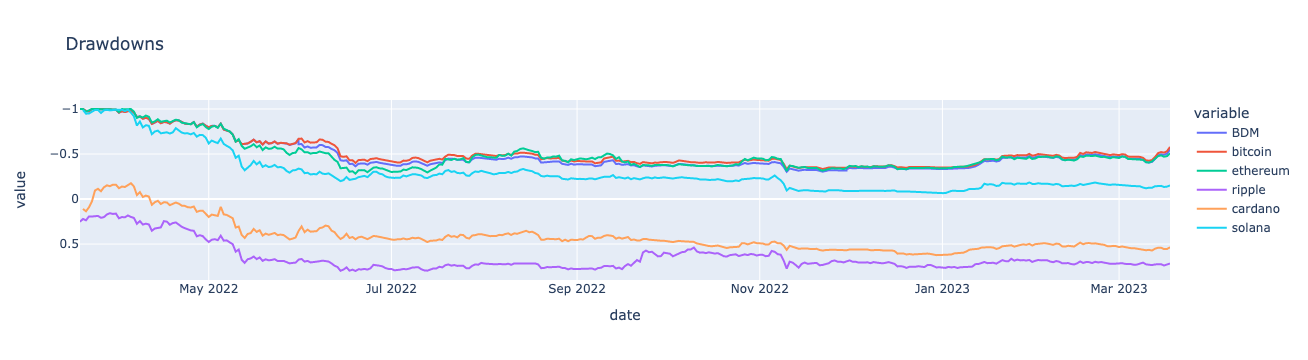

In [82]:
rebal_dd_df = pd.DataFrame(((1-rebal_df['BDM'])/rebal_df['BDM'].cummax()),index=rebal_df.index, columns=['BDM'])

fig = px.line(
    rebal_dd_df,
    x=rebal_dd_df.index,
    y=['BDM'],
    title='Drawdowns'
)
for coin in ['bitcoin','ethereum','ripple','cardano','solana']:
    fig.add_scatter(
        x=bdm_price_df.index,
        y=(1-bdm_price_df[coin])/bdm_price_df[coin].cummax(),
        name=f'{coin}'
    )

fig.update_yaxes(autorange='reversed',rangemode='tozero')
fig.show()

In [83]:
bdm_volume_df['total-other'] = bdm_volume_df.drop(columns=['bitcoin','ethereum']).sum(axis=1)
bdm_volume_norm_df = bdm_volume_df[['bitcoin','ethereum','total-other']].copy()
bdm_volume_norm_df['total'] = bdm_volume_norm_df.sum(axis=1)

for coin in bdm_volume_norm_df.columns.values:
    bdm_volume_norm_df[coin] = bdm_volume_norm_df[coin]/bdm_volume_norm_df['total']

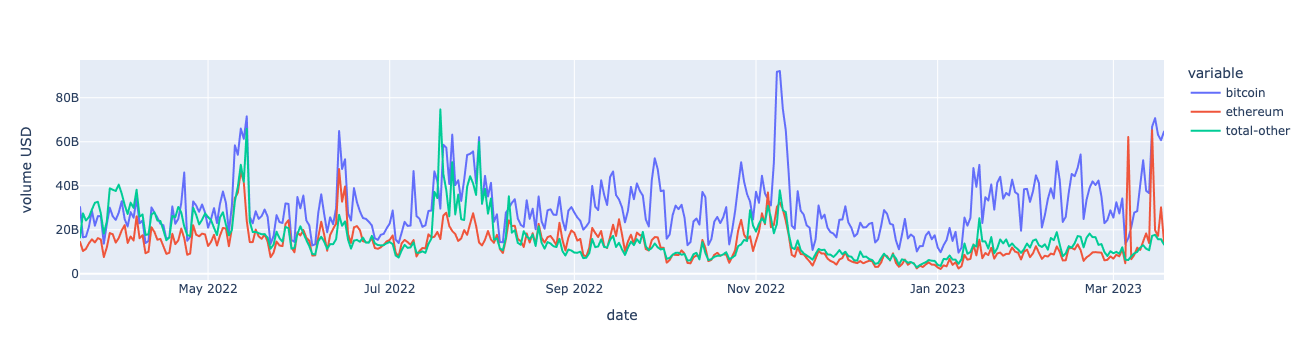

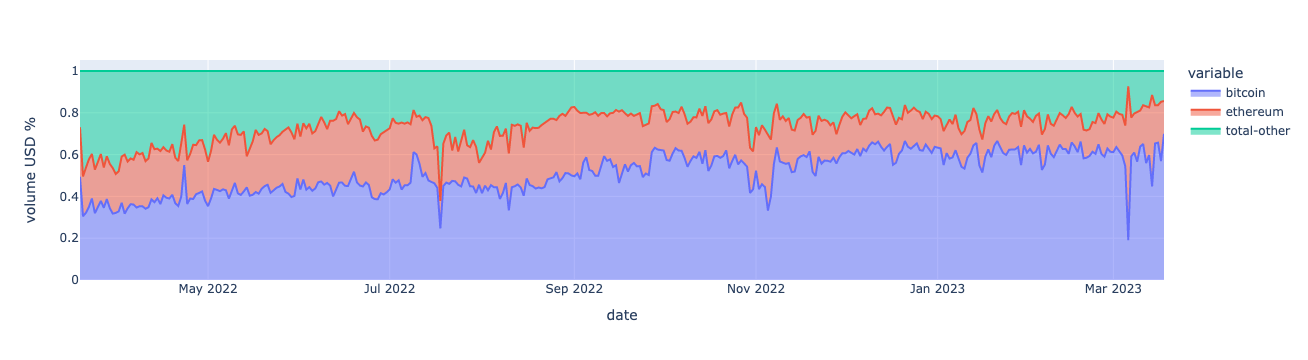

In [85]:
fig = px.line(
    bdm_volume_df,
    x=bdm_volume_df.index,
    y=['bitcoin','ethereum','total-other'],
    labels={'value':'volume USD'}
)
fig.show()

fig = px.area(
    bdm_volume_norm_df,
    x=bdm_volume_norm_df.index,
    y=['bitcoin','ethereum','total-other'],
    labels={'value':'volume USD %'}
)
fig.show()

## Index Segmentation
***

Given Bitcoin's high dominance followed by Ethereum, the BDM is less useful as a benchmark for the crypto economy/ecosystem which is comprised of many more tokens with varying utility. For example, Bitcoin has little usage in DeFi. Centralized exchange volume do not reflect on-chain activity.

There are many ways to segment tokens for more accurate representation of their underlying. For now we will continue to follow S&P's methodology by segmenting by market cap using k-mean clusters.

### Market Cap Segmentation with k-means 

In [3]:
bdm_price_df

NameError: name 'bdm_price_df' is not defined

## References

1. S&P Crypto Methodology: https://www.spglobal.com/spdji/en/documents/methodologies/methodology-sp-digital-market-indices.pdf
2. S&P Crpyto Index Math:https://www.spglobal.com/spdji/en/documents/methodologies/methodology-sp-digital-assets-indices-policies-practices-index-math.pdf
3. Circle Euro-Coin: https://www.circle.com/en/euro-coin
4. mStable mUSD: https://docs.mstable.org/assets/musd